In [105]:
from math import asin, pi, sqrt
import matplotlib.pyplot as plt
import numpy as np
import math
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute,QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.converters.circuit_to_gate import circuit_to_gate
from qiskit.transpiler.passes import RemoveBarriers


# 0. Taking Input and Intitalizing the circuit

In [143]:
#Taking values of Ry from the user and store in list y

y = [float(y) for y in input("Enter multiple values of Ry(use space after each value): ").split()]


Enter multiple values of Ry(use space after each value): 0.2 1.6 2.0 1.8


In [144]:
#Taking values of the basis state from user and storing in list x

x = [int(x) for x in input("Enter multiple values of basis( use space after each digit): ").split()]
if len(x)<len(y):
    print("Qubits in Basis state cannot be smaller than number of rotation gates")
    x = [int(x) for x in input("Enter multiple values of basis( use space after each digit): ").split()]
print("Number of list is: ", x)
lg=len(x)
print("Number of qubits:",lg)

Enter multiple values of basis( use space after each digit): 1 0 1
Qubits in Basis state cannot be smaller than number of rotation gates
Enter multiple values of basis( use space after each digit): 1 0 0 1
Number of list is:  [1, 0, 0, 1]
Number of qubits: 4


In [145]:
n= int(input("Enter the value of n for precision 2^-n:"))

Enter the value of n for precision 2^-n:4


In [146]:
#Finding occurences of 0 in list x from MSB to LSB and storing in control0 list

control0= []   
for i in range(len(x)):
    if x[i]==0:
        control0.append(i)
print(control0)
len(control0)


[1, 2]


2

In [147]:
#Finding the occurences of 0 in list x from LSB to MSB with help of control0 list. as Qiskit qubits go from LSB to MSB

list0 =len(control0)
qubits0=[]
for i in range(1,list0+1):
    qubits0.append((len(x)-1)-control0[-i])
print(qubits0)

[1, 2]


In [148]:
#Defining intializing circuit u_init for len(y) number of angles

def u_init():
    qr = QuantumRegister(len(y))
    qc = QuantumCircuit(qr)
    for i in range(len(y)):
        qc.ry(y[i],i)
   
    return qr,qc

qr,qc = u_init()
qc.draw()

┌─────────┐
q489_0: ┤ Ry(0.2) ├
        ├─────────┤
q489_1: ┤ Ry(1.6) ├
        └┬───────┬┘
q489_2: ─┤ Ry(2) ├─
        ┌┴───────┴┐
q489_3: ┤ Ry(1.8) ├
        └─────────┘

# 1. Amplitude Amplification

In [149]:
# Create a labelling  circuit with a given length register and add a label qubit using mct

def label_state(qr:QuantumRegister) -> QuantumCircuit:
     
    label_qubit = QuantumRegister(1)
    qc_label = QuantumCircuit(qr,label_qubit)
    qc_label.barrier()
    for q in range(len(qubits0)):
            qc_label.x(qubits0[q])
    qc_label.mct(list(range(lg)),label_qubit[0])
    for r in range(len(qubits0)):
            qc_label.x(qubits0[r])
    qc_label.barrier()       
    return label_qubit, qc_label

In [150]:
#Draw the Labelling circuit qc_label

label_qubit, qc_label = label_state(qr)

qc_label.draw()


░                 ░ 
q489_0: ─░────────■────────░─
         ░ ┌───┐  │  ┌───┐ ░ 
q489_1: ─░─┤ X ├──■──┤ X ├─░─
         ░ ├───┤  │  ├───┤ ░ 
q489_2: ─░─┤ X ├──■──┤ X ├─░─
         ░ └───┘  │  └───┘ ░ 
q489_3: ─░────────■────────░─
         ░      ┌─┴─┐      ░ 
q490_0: ─░──────┤ X ├──────░─
         ░      └───┘      ░

In [151]:
#Combine Intialized circuit(qc) and Labelling Circuit(qc_label) to create a A(qc_oracle)

qc_oracle = qc + qc_label
simulator = Aer.get_backend('statevector_simulator')
result = execute(qc_oracle, simulator).result()
statevector = result.get_statevector(qc_oracle)
print(statevector)

[0.23282504+0.j 0.02336042+0.j 0.23972564+0.j 0.02405279+0.j
 0.36260351+0.j 0.0363817 +0.j 0.37335056+0.j 0.03746001+0.j
 0.29339639+0.j 0.        +0.j 0.30209223+0.j 0.03031032+0.j
 0.4569378 +0.j 0.0458467 +0.j 0.47048077+0.j 0.04720553+0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.02943783+0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j]


In [152]:
qc_oracle.draw()

┌─────────┐ ░                 ░ 
q489_0: ┤ Ry(0.2) ├─░────────■────────░─
        ├─────────┤ ░ ┌───┐  │  ┌───┐ ░ 
q489_1: ┤ Ry(1.6) ├─░─┤ X ├──■──┤ X ├─░─
        └┬───────┬┘ ░ ├───┤  │  ├───┤ ░ 
q489_2: ─┤ Ry(2) ├──░─┤ X ├──■──┤ X ├─░─
        ┌┴───────┴┐ ░ └───┘  │  └───┘ ░ 
q489_3: ┤ Ry(1.8) ├─░────────■────────░─
        └─────────┘ ░      ┌─┴─┐      ░ 
q490_0: ────────────░──────┤ X ├──────░─
                    ░      └───┘      ░

In [153]:
# Inserting label 1 in list x, thereby representing the labelled input state |1>|G>
# finding the decimal equivalent of modified list

print("Before insertion" , x)
x.insert(0,1)
print(x)
bnum = ''.join([str(elem) for elem in x])
print(bnum)
dnum= int(bnum, 2)
print('The decimal conversion is:', dnum)

Before insertion [1, 0, 0, 1]
[1, 1, 0, 0, 1]
11001
The decimal conversion is: 25


In [154]:
# For Testing of Amplification part- 
#finding the optimal number 𝑘  of Grover iterators we need to implement

alpha_G = sqrt(abs(statevector[dnum])**2)
k = (pi/(2*asin(alpha_G)) - 1)/2
k = round(k)
print(k)

26


In [155]:
#Creating circuit that reflects across  |0⟩|𝐵⟩
#label_qubit: the qubit that indicates which states have the least significant qubit equal to |1>

def first_reflection(label_qubit: QuantumRegister) -> QuantumCircuit:
    qc = QuantumCircuit(label_qubit)
    qc.z(label_qubit[0])
    return qc

In [156]:
first_reflection_qc = first_reflection(label_qubit)
first_reflection_qc.draw()

┌───┐
q490_0: ┤ Z ├
        └───┘

In [157]:
#building the circuit that implements  𝑆𝜓 , which is a reflection across  |𝜓⟩
#For this, we break it down into  𝐴𝑆0𝐴−1  where  𝑆0  is a reflection across the  |000>  state.

def second_reflection(qr: QuantumRegister, label_qubit: QuantumRegister, qc_oracle: QuantumCircuit) -> QuantumCircuit:

    # Circuit 1: create circuit for A^-1
    qc_inverse = qc_oracle.inverse()
    # Circuit 2: create circuit S_0:
    # 1. Add ancilla qubits to circuit
    ancilla_qubits = QuantumRegister(1)
    qc_reflect = QuantumCircuit(qr, label_qubit, ancilla_qubits)
    # 2. Reflect label |000>
    qc_reflect.barrier()
    for h in range(lg):
            qc_reflect.x(qr[h])
    qc_reflect.x(label_qubit)
    qc_reflect.barrier()
    qc_reflect.mct(list(range(lg+1)),ancilla_qubits[0])
    qc_reflect.barrier()   
    # 3. Perform reflection
    qc_reflect.x(ancilla_qubits[0])
    qc_reflect.z(ancilla_qubits[0])
    qc_reflect.x(ancilla_qubits[0])
    qc_reflect.barrier()
    # 4. Uncompute ancilla qubits used to label |000>
    qc_reflect.mct(list(range(lg+1)),ancilla_qubits[0])
    qc_reflect.barrier()
    for j in range(lg):
            qc_reflect.x(qr[j])
    qc_reflect.x(label_qubit)
    
    # Circuit 3: create circuit for A (do nothing, just use qc_oracle)
    
    # Combine all 3 circuits
    qc = qc_inverse + qc_reflect + qc_oracle 
    return ancilla_qubits, qc

In [158]:
ancilla_qubits, second_reflection_qc = second_reflection(qr, label_qubit, qc_oracle)
second_reflection_qc.draw()

░                 ░ ┌──────────┐ ░ ┌───┐ ░       ░                 ░ »
q489_0: ─░────────■────────░─┤ Ry(-0.2) ├─░─┤ X ├─░───■───░─────────────────░─»
         ░ ┌───┐  │  ┌───┐ ░ ├──────────┤ ░ ├───┤ ░   │   ░                 ░ »
q489_1: ─░─┤ X ├──■──┤ X ├─░─┤ Ry(-1.6) ├─░─┤ X ├─░───■───░─────────────────░─»
         ░ ├───┤  │  ├───┤ ░ └┬────────┬┘ ░ ├───┤ ░   │   ░                 ░ »
q489_2: ─░─┤ X ├──■──┤ X ├─░──┤ Ry(-2) ├──░─┤ X ├─░───■───░─────────────────░─»
         ░ └───┘  │  └───┘ ░ ┌┴────────┴┐ ░ ├───┤ ░   │   ░                 ░ »
q489_3: ─░────────■────────░─┤ Ry(-1.8) ├─░─┤ X ├─░───■───░─────────────────░─»
         ░      ┌─┴─┐      ░ └──────────┘ ░ ├───┤ ░   │   ░                 ░ »
q490_0: ─░──────┤ X ├──────░──────────────░─┤ X ├─░───■───░─────────────────░─»
         ░      └───┘      ░              ░ └───┘ ░ ┌─┴─┐ ░ ┌───┐┌───┐┌───┐ ░ »
q505_0: ──────────────────────────────────░───────░─┤ X ├─░─┤ X ├┤ Z ├┤ X ├─░─»
                                          ░       ░ └───┘ ░ └───┘└───┘└───┘ ░ »
«              ░ ┌───┐┌─────────┐ ░                 ░ 
«q489_0: ──■───░─┤ X ├┤ Ry(0.2) ├─░────────■────────░─
«          │   ░ ├───┤├─────────┤ ░ ┌───┐  │  ┌───┐ ░ 
«q489_1: ──■───░─┤ X ├┤ Ry(1.6) ├─░─┤ X ├──■──┤ X ├─░─
«          │   ░ ├───┤└┬───────┬┘ ░ ├───┤  │  ├───┤ ░ 
«q489_2: ──■───░─┤ X ├─┤ Ry(2) ├──░─┤ X ├──■──┤ X ├─░─
«          │   ░ ├───┤┌┴───────┴┐ ░ └───┘  │  └───┘ ░ 
«q489_3: ──■───░─┤ X ├┤ Ry(1.8) ├─░────────■────────░─
«          │   ░ ├───┤└─────────┘ ░      ┌─┴─┐      ░ 
«q490_0: ──■───░─┤ X ├────────────░──────┤ X ├──────░─
«        ┌─┴─┐ ░ └───┘            ░      └───┘      ░ 
«q505_0: ┤ X ├─░──────────────────────────────────────
«        └───┘ ░

In [159]:
#Putting the two reflection together to obtain the Gover operator
grover_operator = first_reflection_qc + second_reflection_qc
grover_operator.draw()

┌───┐ ░      ┌───┐      ░              ░ ┌───┐ ░       ░           »
q490_0: ┤ Z ├─░──────┤ X ├──────░──────────────░─┤ X ├─░───■───░───────────»
        └───┘ ░      └─┬─┘      ░ ┌──────────┐ ░ ├───┤ ░   │   ░           »
q489_0: ──────░────────■────────░─┤ Ry(-0.2) ├─░─┤ X ├─░───■───░───────────»
              ░ ┌───┐  │  ┌───┐ ░ ├──────────┤ ░ ├───┤ ░   │   ░           »
q489_1: ──────░─┤ X ├──■──┤ X ├─░─┤ Ry(-1.6) ├─░─┤ X ├─░───■───░───────────»
              ░ ├───┤  │  ├───┤ ░ └┬────────┬┘ ░ ├───┤ ░   │   ░           »
q489_2: ──────░─┤ X ├──■──┤ X ├─░──┤ Ry(-2) ├──░─┤ X ├─░───■───░───────────»
              ░ └───┘  │  └───┘ ░ ┌┴────────┴┐ ░ ├───┤ ░   │   ░           »
q489_3: ──────░────────■────────░─┤ Ry(-1.8) ├─░─┤ X ├─░───■───░───────────»
              ░                 ░ └──────────┘ ░ └───┘ ░ ┌─┴─┐ ░ ┌───┐┌───┐»
q505_0: ───────────────────────────────────────░───────░─┤ X ├─░─┤ X ├┤ Z ├»
                                               ░       ░ └───┘ ░ └───┘└───┘»
«              ░       ░ ┌───┐            ░      ┌───┐      ░ 
«q490_0: ──────░───■───░─┤ X ├────────────░──────┤ X ├──────░─
«              ░   │   ░ ├───┤┌─────────┐ ░      └─┬─┘      ░ 
«q489_0: ──────░───■───░─┤ X ├┤ Ry(0.2) ├─░────────■────────░─
«              ░   │   ░ ├───┤├─────────┤ ░ ┌───┐  │  ┌───┐ ░ 
«q489_1: ──────░───■───░─┤ X ├┤ Ry(1.6) ├─░─┤ X ├──■──┤ X ├─░─
«              ░   │   ░ ├───┤└┬───────┬┘ ░ ├───┤  │  ├───┤ ░ 
«q489_2: ──────░───■───░─┤ X ├─┤ Ry(2) ├──░─┤ X ├──■──┤ X ├─░─
«              ░   │   ░ ├───┤┌┴───────┴┐ ░ └───┘  │  └───┘ ░ 
«q489_3: ──────░───■───░─┤ X ├┤ Ry(1.8) ├─░────────■────────░─
«        ┌───┐ ░ ┌─┴─┐ ░ └───┘└─────────┘ ░                 ░ 
«q505_0: ┤ X ├─░─┤ X ├─░──────────────────────────────────────
«        └───┘ ░ └───┘ ░

In [160]:
#removing the label 1 from list x
x.pop(0)
print(x)

[1, 0, 0, 1]


In [161]:
#For Testing of Amplification part
# Putting together operator A(qc_oracle) and Q(grover_operator) for Amplitude Amplification
final_qc = qc_oracle.copy()
for _ in range(k):
    final_qc += grover_operator
result = execute(final_qc, simulator).result()
statevector = result.get_statevector(final_qc)

final_prob = abs(statevector[dnum])**2
assert final_prob > 0.99, f'your final probability of measuring |{x}> is {final_prob} which is less than 0.99'
print(f'Congratulations! Your final probability of measuring |{x}> is {final_prob}')

Congratulations! Your final probability of measuring |[1, 0, 0, 1]> is 0.9998925519281281


# 2.Phase Estimation using Controlled Grover operator 

In [162]:
# Converting qc_oracle Circuit to Gate A 
qc_oracle = RemoveBarriers()(qc_oracle)
A = circuit_to_gate(qc_oracle)

In [163]:
# Applying H gate to ancilla qubits and A gate to the remaining qubits of Phase Estimation Circuit 
qreg = QuantumRegister(n+lg+2)
creg = ClassicalRegister(n)
qpe = QuantumCircuit(qreg,creg)
for qubit in range(n):
    qpe.h(qubit)
ap=list(np.arange(n,n+lg+1))
qpe.append(A,ap)
qpe.barrier()
qpe.draw()

┌───┐        ░ 
q546_0: ──────┤ H ├────────░─
              ├───┤        ░ 
q546_1: ──────┤ H ├────────░─
              ├───┤        ░ 
q546_2: ──────┤ H ├────────░─
              ├───┤        ░ 
q546_3: ──────┤ H ├────────░─
        ┌─────┴───┴──────┐ ░ 
q546_4: ┤0               ├─░─
        │                │ ░ 
q546_5: ┤1               ├─░─
        │                │ ░ 
q546_6: ┤2 circuit-21574 ├─░─
        │                │ ░ 
q546_7: ┤3               ├─░─
        │                │ ░ 
q546_8: ┤4               ├─░─
        └────────────────┘ ░ 
q546_9: ───────────────────░─
                           ░ 
  c8: 4/═════════════════════

In [164]:
#  For Testing
#Iteratively generating list qp of different length for each instance of controlled Q
#It shows the qubit numbers of Phase estimation circuit to which each instance of Controlled Q(....Q^4, Q^2, Q^1) gets appended to
for i in range(n):
    j =i +1
    qp =list(np.arange(n-j,n+lg+2))
    print(" ")
    for l in range(len(qp)):
           print(qp[l])

 
3
4
5
6
7
8
9
 
2
3
4
5
6
7
8
9
 
1
2
3
4
5
6
7
8
9
 
0
1
2
3
4
5
6
7
8
9


In [165]:
#n- is the number of ancilla qubits used in Phase estimation
#Appending controlled Q(.....Q^4,Q^2,Q^1) operators to the Pase Estimation circuit

grover_operator = RemoveBarriers()(grover_operator)
i=0
qp=list(np.arange(n,n+lg+2))
c= n-1
for c in range(c,-1,-1):
     
     Q = circuit_to_gate(grover_operator).control().power(2**c)
        
     qpe.append(Q,[c]+qp)
    
qpe.draw()

┌───┐        ░                                           »
q546_0: ──────┤ H ├────────░───────────────────────────────────────────»
              ├───┤        ░                                           »
q546_1: ──────┤ H ├────────░───────────────────────────────────────────»
              ├───┤        ░                      ┌───────────────────┐»
q546_2: ──────┤ H ├────────░──────────────────────┤0                  ├»
              ├───┤        ░ ┌───────────────────┐│                   │»
q546_3: ──────┤ H ├────────░─┤0                  ├┤                   ├»
        ┌─────┴───┴──────┐ ░ │                   ││                   │»
q546_4: ┤0               ├─░─┤1                  ├┤1                  ├»
        │                │ ░ │                   ││                   │»
q546_5: ┤1               ├─░─┤2                  ├┤2                  ├»
        │                │ ░ │                   ││  ccircuit-21725^4 │»
q546_6: ┤2 circuit-21574 ├─░─┤3 ccircuit-21725^8 ├┤3                  ├»
        │                │ ░ │                   ││                   │»
q546_7: ┤3               ├─░─┤4                  ├┤4                  ├»
        │                │ ░ │                   ││                   │»
q546_8: ┤4               ├─░─┤5                  ├┤5                  ├»
        └────────────────┘ ░ │                   ││                   │»
q546_9: ───────────────────░─┤6                  ├┤6                  ├»
                           ░ └───────────────────┘└───────────────────┘»
  c8: 4/═══════════════════════════════════════════════════════════════»
                                                                       »
«                             ┌───────────────────┐
«q546_0: ─────────────────────┤0                  ├
«        ┌───────────────────┐│                   │
«q546_1: ┤0                  ├┤                   ├
«        │                   ││                   │
«q546_2: ┤                   ├┤                   ├
«        │                   ││                   │
«q546_3: ┤                   ├┤                   ├
«        │                   ││                   │
«q546_4: ┤1                  ├┤1                  ├
«        │                   ││  ccircuit-21725^1 │
«q546_5: ┤2 ccircuit-21725^2 ├┤2                  ├
«        │                   ││                   │
«q546_6: ┤3                  ├┤3                  ├
«        │                   ││                   │
«q546_7: ┤4                  ├┤4                  ├
«        │                   ││                   │
«q546_8: ┤5                  ├┤5                  ├
«        │                   ││                   │
«q546_9: ┤6                  ├┤6                  ├
«        └───────────────────┘└───────────────────┘
«  c8: 4/══════════════════════════════════════════
«

In [134]:
# n- number of ancilla qubits
# Creating n-qubit QFTdagger the first n qubits in circ
def qft_dagger(qc, n):
    qc.h(n-1)
    j=1
    for j in range(1,n):
        l=0
        m=1
        for m in range(1,j+1):
            qc.cp(-math.pi/float(2**(m)), (n-j)+l, (n-(j+1)))
            print((n-j)+l,'is the control',end= '   ')
            print((n-(j+1)),'is the target')
            l += 1
            
        qc.h((n-(j+1)))

In [166]:
#For Testing QFTdagger
test= QuantumCircuit(6)
qft_dagger(test,4)
test.draw()

3 is the control   2 is the target
2 is the control   1 is the target
3 is the control   1 is the target
1 is the control   0 is the target
2 is the control   0 is the target
3 is the control   0 is the target


»
q_0: ──────────────────────────────────────────────■─────────■────────»
                                             ┌───┐ │P(-π/2)  │        »
q_1: ─────────────────────■─────────■────────┤ H ├─■─────────┼────────»
                    ┌───┐ │P(-π/2)  │        └───┘           │P(-π/4) »
q_2: ──────■────────┤ H ├─■─────────┼────────────────────────■────────»
     ┌───┐ │P(-π/2) └───┘           │P(-π/4)                          »
q_3: ┤ H ├─■────────────────────────■─────────────────────────────────»
     └───┘                                                            »
q_4: ─────────────────────────────────────────────────────────────────»
                                                                      »
q_5: ─────────────────────────────────────────────────────────────────»
                                                                      »
«               ┌───┐
«q_0: ─■────────┤ H ├
«      │        └───┘
«q_1: ─┼─────────────
«      │             
«q_2: ─┼─────────────
«      │P(-π/8)      
«q_3: ─■─────────────
«                    
«q_4: ───────────────
«                    
«q_5: ───────────────
«

In [167]:
#Applying QFTdagger to first n-qubits of Phase Estimation circuit
#Measuring the results

qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, n)
# Measure
qpe.barrier()
for g in range(n):
    qpe.measure(g,g)

3 is the control   2 is the target
2 is the control   1 is the target
3 is the control   1 is the target
1 is the control   0 is the target
2 is the control   0 is the target
3 is the control   0 is the target


In [168]:
qpe.draw()

┌───┐        ░                                           »
q546_0: ──────┤ H ├────────░───────────────────────────────────────────»
              ├───┤        ░                                           »
q546_1: ──────┤ H ├────────░───────────────────────────────────────────»
              ├───┤        ░                      ┌───────────────────┐»
q546_2: ──────┤ H ├────────░──────────────────────┤0                  ├»
              ├───┤        ░ ┌───────────────────┐│                   │»
q546_3: ──────┤ H ├────────░─┤0                  ├┤                   ├»
        ┌─────┴───┴──────┐ ░ │                   ││                   │»
q546_4: ┤0               ├─░─┤1                  ├┤1                  ├»
        │                │ ░ │                   ││                   │»
q546_5: ┤1               ├─░─┤2                  ├┤2                  ├»
        │                │ ░ │                   ││  ccircuit-21725^4 │»
q546_6: ┤2 circuit-21574 ├─░─┤3 ccircuit-21725^8 ├┤3                  ├»
        │                │ ░ │                   ││                   │»
q546_7: ┤3               ├─░─┤4                  ├┤4                  ├»
        │                │ ░ │                   ││                   │»
q546_8: ┤4               ├─░─┤5                  ├┤5                  ├»
        └────────────────┘ ░ │                   ││                   │»
q546_9: ───────────────────░─┤6                  ├┤6                  ├»
                           ░ └───────────────────┘└───────────────────┘»
  c8: 4/═══════════════════════════════════════════════════════════════»
                                                                       »
«                             ┌───────────────────┐ ░                     »
«q546_0: ─────────────────────┤0                  ├─░─────────────────────»
«        ┌───────────────────┐│                   │ ░                     »
«q546_1: ┤0                  ├┤                   ├─░─────────────────────»
«        │                   ││                   │ ░                ┌───┐»
«q546_2: ┤                   ├┤                   ├─░───────■────────┤ H ├»
«        │                   ││                   │ ░ ┌───┐ │P(-π/2) └───┘»
«q546_3: ┤                   ├┤                   ├─░─┤ H ├─■─────────────»
«        │                   ││                   │ ░ └───┘               »
«q546_4: ┤1                  ├┤1                  ├─░─────────────────────»
«        │                   ││  ccircuit-21725^1 │ ░                     »
«q546_5: ┤2 ccircuit-21725^2 ├┤2                  ├─░─────────────────────»
«        │                   ││                   │ ░                     »
«q546_6: ┤3                  ├┤3                  ├─░─────────────────────»
«        │                   ││                   │ ░                     »
«q546_7: ┤4                  ├┤4                  ├─░─────────────────────»
«        │                   ││                   │ ░                     »
«q546_8: ┤5                  ├┤5                  ├─░─────────────────────»
«        │                   ││                   │ ░                     »
«q546_9: ┤6                  ├┤6                  ├─░─────────────────────»
«        └───────────────────┘└───────────────────┘ ░                     »
«  c8: 4/═════════════════════════════════════════════════════════════════»
«                                                                         »
«                                                               ┌───┐ ░ ┌─┐   »
«q546_0: ──────────────────────────■─────────■─────────■────────┤ H ├─░─┤M├───»
«                            ┌───┐ │P(-π/2)  │         │        └───┘ ░ └╥┘┌─┐»
«q546_1: ─■─────────■────────┤ H ├─■─────────┼─────────┼──────────────░──╫─┤M├»
«         │P(-π/2)  │        └───┘           │P(-π/4)  │              ░  ║ └╥┘»
«q546_2: ─■─────────┼────────────────────────■─────────┼──────────────░──╫──╫─»
«                   │P(-π/4)                           │P(-π/8)       ░  ║  ║ »
«q546_3: ───────────■──────

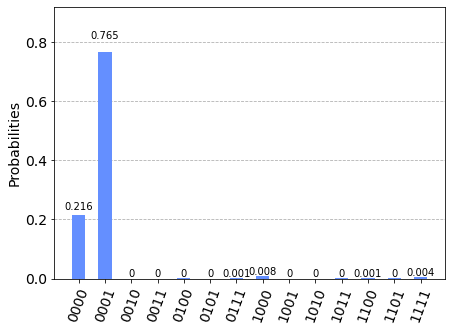

In [169]:
#Executing circuit in simulator and plotting histogram

aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)